<a href="https://colab.research.google.com/github/UvaRoobini/CSE/blob/main/knee_disease_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
import timeit

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight

In [24]:
np.random.seed(12049)

In [25]:
def get_plot_loss_acc(model, model_name):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()


def compute_confusion_matrix(
    ytrue, ypred, class_names, model_name
):
    cm = confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


def get_evaluate(data, name, model):
    score_model = model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]:.2f}")
    print(f"{name} accuracy: {score_model[1]:.2f}")


def get_predict(data, model):
    predict_model = model.predict(data)
    return predict_model


def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

In [26]:
!git clone https://github.com/UvaRoobini/kneedataset.git

fatal: destination path 'kneedataset' already exists and is not an empty directory.


In [27]:
base_dir = "/content/kneedataset"
train_path = os.path.join(base_dir, 'train')
valid_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

In [28]:
model_name = "ResNet50"
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

target_size = (224, 224)
epochs = 100
batch_size = 256
img_shape = (224, 224, 3)

# Save model
save_model_ft = os.path.join("D:/kneeproject", f'resnet50_model.hdf5')

In [29]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

In [30]:
train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 1172 images belonging to 5 classes.
Found 214 images belonging to 5 classes.


In [31]:
y_train = train_generator.labels
y_val = valid_generator.labels

In [32]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 275, 1: 275, 2: 275, 3: 275, 4: 72}
{0: 0.8523636363636363, 1: 0.8523636363636363, 2: 0.8523636363636363, 3: 0.8523636363636363, 4: 3.2555555555555555}


In [33]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01,
                min_lr=1e-10, patience=4, mode='auto'
            )

In [34]:
model = tf.keras.applications.ResNet50(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

In [35]:
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 23544837 (89.82 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [36]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early, plateau],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/100
37/37 [==============================] - 56s 637ms/step - loss: 2.0752 - accuracy: 0.2338 - val_loss: 6026896.0000 - val_accuracy: 0.2336 - lr: 0.0010
Epoch 2/100
37/37 [==============================] - 24s 641ms/step - loss: 1.7802 - accuracy: 0.2432 - val_loss: 10392.2305 - val_accuracy: 0.2009 - lr: 0.0010
Epoch 3/100
37/37 [==============================] - 23s 623ms/step - loss: 1.7308 - accuracy: 0.2406 - val_loss: 75.4405 - val_accuracy: 0.1916 - lr: 0.0010
Epoch 4/100
37/37 [==============================] - 24s 651ms/step - loss: 1.5345 - accuracy: 0.2705 - val_loss: 5.3394 - val_accuracy: 0.2850 - lr: 0.0010
Epoch 5/100
37/37 [==============================] - 24s 645ms/step - loss: 1.3445 - accuracy: 0.3439 - val_loss: 12.5544 - val_accuracy: 0.2336 - lr: 0.0010
Epoch 6/100
37/37 [==============================] - 24s 644ms/step - loss: 1.2360 - accuracy: 0.3805 - val_loss: 12.4973 - val_accuracy: 0.2617 - lr: 0.0010
Epoch 7/100
37/37 [==========================

In [37]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model {model_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model ResNet50 fine tuning executed in 19.69 minutes


In [38]:
model_ft.save(save_model_ft)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


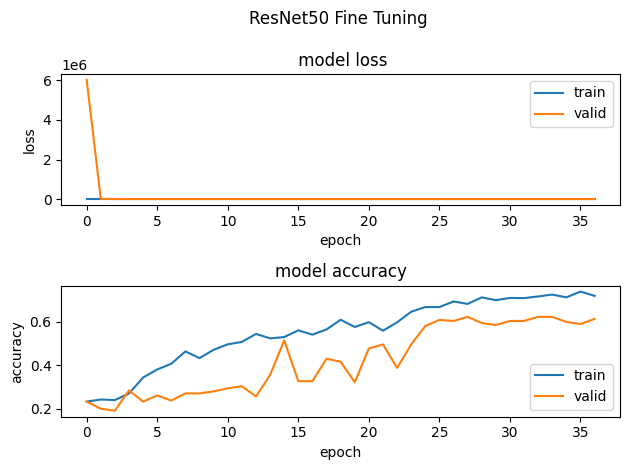

In [39]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [40]:
get_evaluate(valid_generator, "Valid", model_ft)

7/7 [==============================] - 1s 122ms/step - loss: 0.9132 - accuracy: 0.5935
Valid loss: 0.91
Valid accuracy: 0.59


In [41]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

7/7 [==============================] - 2s 115ms/step
Accuracy Score - ResNet50: 0.59
Balanced Accuracy Score - ResNet50: 0.62


              precision    recall  f1-score   support

           0       0.56      0.67      0.61        51
           1       0.45      0.30      0.36        50
           2       0.48      0.56      0.52        50
           3       0.78      0.80      0.79        50
           4       0.91      0.77      0.83        13

    accuracy                           0.59       214
   macro avg       0.64      0.62      0.62       214
weighted avg       0.59      0.59      0.59       214



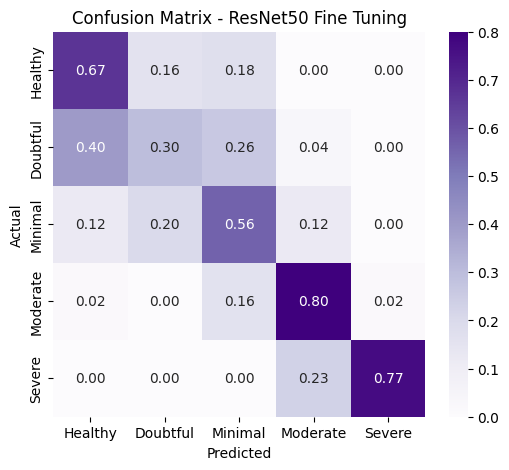

In [42]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)

In [43]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy
model_1 = load_model("C:/Users/yuvas/models/model_ResNet50_ft.hdf5")
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model("C:/Users/yuvas/models/model_Xception_ft.hdf5")
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')
model_3 = load_model("C:/Users/yuvas/models/model_Inception ResNet V2_ft.hdf5")
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')
models = [model_1, model_2,model_3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

OSError: No file or directory found at C:/Users/yuvas/models/model_ResNet50_ft.hdf5

In [ ]:
ensemble_model.compile(optimizer="adam", loss= tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [ ]:
import pathlib
data_dir = pathlib.Path("C:/Users/yuvas/Downloads/kneedataset")
img_height=224
img_width=224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=23 )

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=23 )

In [ ]:
history = ensemble_model.fit(
train_ds,
validation_data=val_ds,
epochs=20
)